# Should your fund invest in Bitcoin?

## 📖 Background
You work as an analyst at an investment fund in New York. Your CFO wants to explore if it is a good idea to invest some of the fund's assets in Bitcoin. You have to prepare a report on this asset and how it compares to the stock market in general.

# Should your fund invest in Bitcoin?

## 📖 Background
You work as an analyst at an investment fund in New York. Your CFO wants to explore if it is a good idea to invest some of the fund's assets in Bitcoin. You have to prepare a report on this asset and how it compares to the stock market in general.

## 💾 The data
You have access to three files:

#### Bitcoin daily data in US dollars
- "date" - date from September 17, 2014 to November 17, 2021
- "open" - the price at the beginning of the trading day
- "high" - the highest price reached that day
- "low" - the lowest price reached that day
- "close" - the price at the closing of the trading day
- "volume" - how many Bitcoin were traded that day

#### S&P 500 daily data
- "date" - date from September 17, 2014 to November 17, 2021
- "open" - the index level at the beginning of the trading day
- "high" - the highest level reached that day
- "low" - the lowest level reached that day
- "close" - the level at the closing of the trading day
- "volume" - how many shares in the companies that make up the index were traded that day

#### inflation and gold as monthly data
- "date" - date from September, 2014 to November, 2021
- "gold_usd" - price in usd of gold for that month
- "cpi_us" - the inflation index for the US for that month (cpi = consumer price index)

_CPI data from the [U.S. Bureau of Labor Statistics](https://www.bls.gov/cpi/). Publicly available information_.

## 💪 Competition challenge
Create a report that covers the following:

1. How does the performance of Bitcoin compare to the S&P 500 and the price of gold?
2. Analyze Bitcoin's returns and volatility profile. Do you believe it could help improve the performance of a portfolio? Do you believe Bitcoin could be used as a hedge versus inflation?
3. The CFO is looking to lower volatility in the fund. Explore building a portfolio using some or all of these assets. Make a recommendation that minimizes overall risk.

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- Remove redundant cells like the judging criteria so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights.
- Check that all the cells run without error.

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Here we have 3 data : inflation/gold, sp500, and bitcoin. Let's first see the data description 


In [2]:

bitcoin = pd.read_csv('./data/bitcoin-usd.csv', parse_dates=['date'])
sp500 = pd.read_csv('./data/sp500.csv', parse_dates=['date'])
monthly_data = pd.read_csv('./data/monthly_data.csv', parse_dates=['date'])


print(sp500.head(2))
print(bitcoin.head(2))
print(monthly_data.head(2))



        date         open         high          low        close      volume
0 2014-09-17  1999.300049  2010.739990  1993.290039  2001.569946  3209420000
1 2014-09-18  2003.069946  2012.339966  2003.069946  2011.359985  3235340000
        date        open        high         low       close      volume
0 2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800.0
1 2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0
        date  gold_usd   cpi_us
0 2014-09-01  1241.330  237.852
1 2014-10-01  1223.565  238.031


The bitcoin and sp500 data start in the mid of September 2014 and end in the mid of November 2021, while inflation data starts at the beginning of september 2014 and end in the beginning of November 2021. 
Because fraction of data mismatch is relatively small, we can  remove the september 2014 and november 2021 data.

In our analysis we want to combine these 3 data into one dataframe structure with daily data starting on start_date and ends on end_date. Because inflation data is available only in the beginning of each month, we need to impute the data, and because inflation changes slowly we can safely assume the inflation between beginning of two months changes linearly.


In [3]:

start_date='2014-10-01'
end_date='2021-10-31'
end_date_temp='2021-11-01'

mask_month=(monthly_data['date']>=start_date) &( monthly_data['date']<=end_date_temp)
mask_sp500=(sp500['date']>=start_date) & (sp500['date']<=end_date_temp)  
mask_bitcoin=(bitcoin['date']>=start_date) & (bitcoin['date']<=end_date_temp)  


monthly_data=monthly_data.loc[mask_month]
sp500=sp500.loc[mask_sp500]
bitcoin=bitcoin.loc[mask_bitcoin]


sp500=pd.merge(bitcoin['date'], sp500, on='date',how='left') 
gold=pd.merge(bitcoin['date'],monthly_data,on='date',how='left')


gold.reset_index(inplace=True)
sp500.reset_index(inplace=True)
bitcoin.reset_index(inplace=True)



Bitcoin, sp500, and gold have missing values. 

1. Fill the missing values in gold using interpolation
2. Fill the missing values in bitcoin using previous day data
3. Fill the missing values in sp500 using data on friday of the week

In [4]:
#Gold : Linear Interpolation
gold=gold.interpolate(method='polynomial', order=1)

#sp500
n_empty1=0
col_fill=['open','high','low','close','volume']

for index,row in sp500[col_fill].iterrows():
    if row.isnull().all()==True:
        n_empty1+=1
        for col in col_fill:
            sp500[col].iloc[index]= sp500[col].iloc[index-1].copy()
        
#Bitcoin
n_empty2=0
col_fill=['open','high','low','close','volume']

for index,row in bitcoin[col_fill].iterrows():
    if row.isnull().any()==True:
        n_empty2+=1
        for col in col_fill:
            bitcoin[col].iloc[index]= bitcoin[col].iloc[index-1].copy()
        


In [5]:
#Check if there is still any missing value
print(gold.isnull().any().any()  ,    sp500.isnull().any().any()  ,bitcoin.isnull().any().any()  )


False False False


Now let's do several final steps in data cleaning & data preparation namely:

1. Let's remove the last row (end_date_temp='2021-11-01') which was temporarily used to interpolate the inflation data.

2. Lets also set the 'date' column as index to make it easier to do data selection.

3. Merge all 3 data into one dataframe for further analysis. For our current purpose we'll only keep the 'close' column.


In [6]:
#Remove the last row
gold=gold.iloc[:-1]
sp500=sp500.iloc[:-1]
bitcoin=bitcoin.iloc[:-1]

#Use date as index
bitcoin=bitcoin.set_index(['date'])
sp500=sp500.set_index(['date'])
gold=gold.set_index(['date'])

#Merge data into one single data frame full_df
full_df=pd.concat( ( bitcoin[['close']],sp500[['close']],gold[['gold_usd']]),axis=1)
full_df.columns=['bitcoin','sp500','gold']

# I. Return Analysis

In the first part we'll analyze the return of these 3 securities in daily and monthly basis

In [7]:
monthly_df = full_df.resample('BMS').first()
returns_daily = full_df.pct_change().dropna()
returns_monthly = monthly_df.pct_change().dropna()


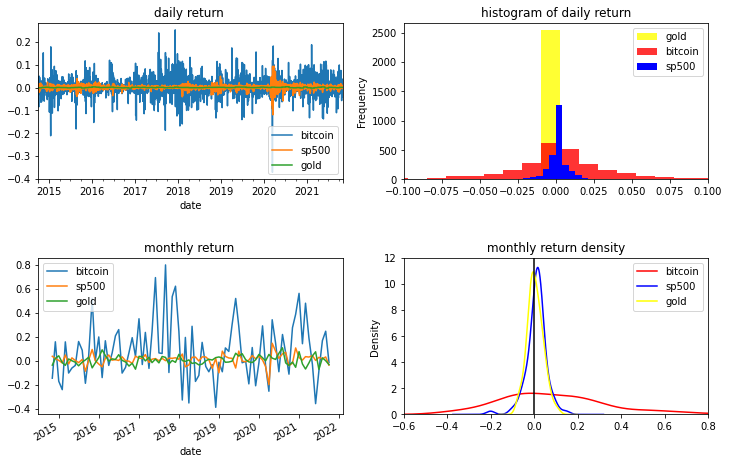

In [8]:

fig,axs=plt.subplots( 2,2,figsize=(12,8))
fig.subplots_adjust(hspace=0.5)


returns_daily.plot(ax=axs[0,0])
returns_daily[['gold','bitcoin']].plot.hist(ax=axs[0,1],bins=50,alpha=0.8,color=['yellow','red'])
returns_daily[['sp500']].plot.hist(ax=axs[0,1],bins=50,alpha=1,color='blue')
axs[0,1].set_xlim(-0.1,0.1)

axs[0,1].set_title('histogram of daily return')

axs[0,0].set_title('daily return ')



returns_monthly.plot(ax=axs[1,0])
returns_monthly.plot.kde(ax=axs[1,1],color=['red','blue','yellow'])

axs[1,1].set_xlim(-0.6,0.8)
axs[1,1].set_ylim(0,12)
axs[1,1].plot( [0,0],[0,12],color='black')

axs[1,0].set_title('monthly return ')
axs[1,1].set_title(' monthly return density ')

axs[0,0].legend()
axs[1,0].legend()
axs[1,1].legend()






From plot of daily returns it is clear that bitcoin is the most volatile security, while gold is the least. However it is not clear if bitcoin offers return that is in average better than the other two. 

This is why we need to have the second plot, in which we plot the monthly return. From this plot, it is clear that sp500 is shifted to the right compared to gold, meaning a higher average of return. Interestingly there is a little peak on the left of sp500 plot which indicates extra probability (although quite small) of negative return , meaning sp500 is riskier than gold.

On the other hand, bitcoin follows positvely-skewed distribution which means highest average positive return. However it is also clear that bitcoin has signifficant negative return distribution, meaning the riskiest of all three securities.



## Investment Growth

Our analysis demonstrates that bitcoin  has the highest average return, but it also comes with highest volatility. It will also be interesting to see how much gain we have now from investing in bitcoin in early 2014. In the following we plot of value of portfolios of these 3 assets starting from 2014. The plot on the right, although not complete, seems to indicate that there is correlation between sp500 and bitcoin in the last 2-3 years, when bitcoin prices skyrocketed.

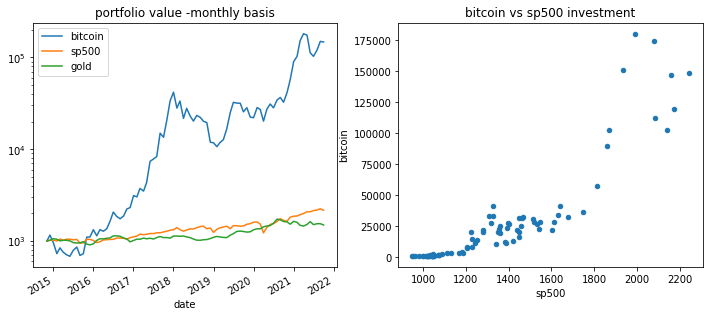

In [9]:
a=[[0]*3]*(returns_monthly.shape[0])
invest=pd.DataFrame( a,columns=['bitcoin','sp500','gold'])
invest.set_index(  returns_monthly.index,inplace=True)

cash=1000
invest.iloc[0]=[cash]*3

fig,axs=plt.subplots( 1,2,figsize=(12,5))

def plot_returns_all(returns_monthly,invest):
    for i in range(1, invest.shape[0]):
        invest.iloc[i]=np.multiply( invest.iloc[i-1], 1+returns_monthly.iloc[i]  )
    
    invest.plot(logy=True,title='portfolio value -monthly basis',ax=axs[0])
    invest.plot(x='sp500',y='bitcoin',kind='scatter',ax=axs[1],title='bitcoin vs sp500 investment' )
plot_returns_all(returns_monthly,invest)

# II. Return to Risk Profile


The plot above is the plot of three assest if their monthly returns are compounded. If we invest in bitcoin in early 2016 the value is up by 100x by now, but we you invest in early 2018, the value will be up by 3x-6x by now. The rapid decrease of multiplication factor leaves us with big question, if it is still good idea to invest in bitcoin today. Below we plot return to risk profile of these three assets. 



Text(0.5, 1.0, ' monthly Sharpe Ratio')

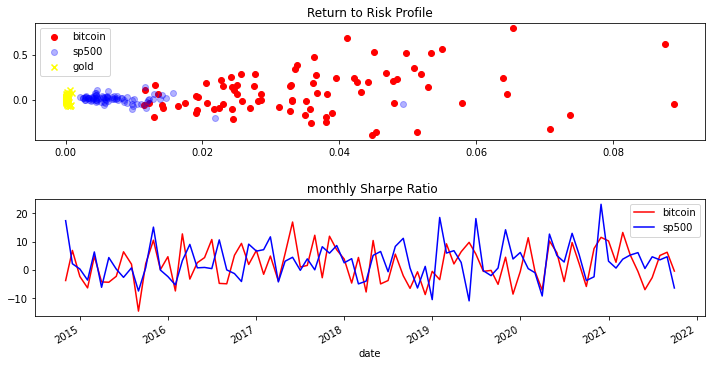

In [10]:
a=[[0]*3]*(returns_monthly.shape[0])
volatility_monthly=pd.DataFrame( a,columns=['bitcoin','sp500','gold'])
volatility_monthly.set_index(  returns_monthly.index,inplace=True)
rtd_idx = returns_daily.index

for i in returns_monthly.index: 
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    volatility_monthly.loc[i]=returns_daily[mask].std()
    
fig,axs=plt.subplots( 2,1,figsize=(12,6))

axs[0].scatter( volatility_monthly['bitcoin'],returns_monthly['bitcoin'] ,color='red',label='bitcoin' )
axs[0].scatter( volatility_monthly['sp500'],returns_monthly['sp500'] ,color='blue',alpha=0.3,label='sp500')
axs[0].scatter( volatility_monthly['gold'],returns_monthly['gold'] ,color='yellow',alpha=1,marker='x',label='gold')
axs[0].legend()
axs[0].set_title( 'Return to Risk Profile')

fig.subplots_adjust(hspace=0.5)

Sharpe_ratio=(volatility_monthly.copy())
Sharpe_ratio['bitcoin']=returns_monthly['bitcoin']/volatility_monthly['bitcoin']
Sharpe_ratio['sp500']=returns_monthly['sp500']/volatility_monthly['sp500']
Sharpe_ratio['gold']=returns_monthly['gold']/volatility_monthly['gold']


Sharpe_ratio[['bitcoin','sp500']].plot(ax=axs[1],color=['red','blue','yellow'])
axs[1].set_title (' monthly Sharpe Ratio')






In the plot of Risk to Return, we can clearly identify three different clusters of these 3 assets, and we can also clearly notice the different in size of these 3 clusters. As we have concluded before, we see the order of both volatility and return spread of these 3 assets.

Although sp500 and bicoin are different in both clusters and cluster size, but they do share the similar magnitude of sharpe ratio, which is defined as return per volatility, and this is shown in plot of monthly sharpe ratio. This seems to imply that bitcoin is traded in the similar way the stock is (stock-like behaviour).
This is a fruitful insight as it provides us clues to construct a portfolio of investment that includes bitcoin, and jutifies the use of Modern Portfolio Theory to study such portfolio.

{Volatily_monthly that we calculated above is actually daily volatility calculated in each month. To get the estimate of "actual" monthly volatility , daily volatility needs to be multiplied by square root of number of days in a month :$\sqrt 30$}


Normally we use less volatile asset such as gold, to hedge against the inflation. Therefore in normal situation we do not suggest using bitcoin to hedge against inflation. However bitcoin is unique, because in addition to stock-like behaviour, it also has limited number, so in principle price of bitcoin can increase the way gold does.  (As of today there is only less than 10% bitcoin left to mine)




## Geometric Brownian Motion

If we want to use bitcoin as hedging against inflation, we need to first analyze how much its price increases in the presence of fluctuations. We need to be able to separate bitcoin drift ($\mu$) price increases from it's highly volatile price changes ($\sigma $). One possible way to do this is by modeling the bitcoin prices using geometric brownian motion (GBM)

$dS_t=\mu S_t dt + \sigma S_t dW_t $

The volatility is obivously a function of time (as shown in plot below), which does not fit the assumption of typical geometric brownian motion. However the rolling volatility of bitoin is bounded between  0.16 and 0.23, with average of 0.2, which motivates me to do the distribution fit and check the fitted parameters: $\mu$ and $\sigma$. ( rolling volatility of sp500 is between 0.04 and 0.05)

The solution of GBM is given by:   $ \ln (S(t)/S(0)) = (\mu - \sigma^2/2)t +\sigma W_t  $

Text(0.5, 1.0, 'Monthly volatility of sp500 and bitcoin')

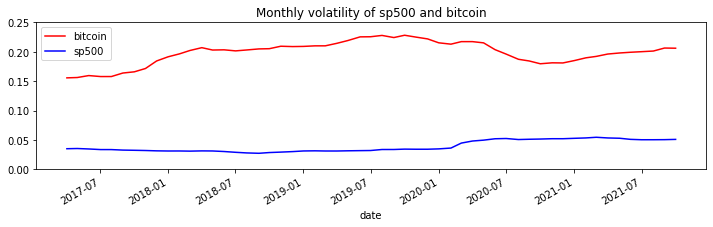

In [11]:

fig2,axs2=plt.subplots( 1,1,figsize=(12,3))
volatility_monthly=volatility_monthly*np.sqrt(30)  #Multiply by sqrt(30) to get monthly vol
volatility_monthly[['bitcoin','sp500']].rolling(30).mean().plot(ax=axs2,color=['red','blue'])
axs2.set_ylim(0,0.25)
axs2.set_title('Monthly volatility of sp500 and bitcoin')



if we use time step of 1 month , the term on GBM is related to our return_monthly :



$ \ln (S(t)/S(0))$ =ln ( 1+ return_monthly)

and $\sigma $ = volatility_monthly x $\sqrt 30$
    
Therefore the next step is done to fit the y=$ \ln (S(t)/S(0)) + \sigma^2/2$ to normal distribution, to find $\mu$ and $\sigma$.


In [12]:
from scipy.stats import norm
ln_returns_monthly=np.log(1+returns_monthly)

y_sp=ln_returns_monthly[['sp500']]+ (volatility_monthly[['sp500']]) **2/2
y_bit=ln_returns_monthly[['bitcoin']]+ (volatility_monthly[['bitcoin']])**2/2


mu_sp,sigma_sp=norm.fit(y_sp)
mu_bit,sigma_bit=norm.fit(y_bit)

print(mu_sp,sigma_sp)
print(mu_bit,sigma_bit)

0.010922344117628536 0.045893302642113866
0.08052168598998403 0.22518596987270334


The calculations show that fitted sigma for sp500 and bitcoin is still in the range of pre-calculated averaged volatility, which means although the model is far from perfect, but it is able to capture the magnitude of volatility.

Furthermore, the drift of sp500 and bitcoin ares 1% and 8% on monthly basis, which is also good news. This means that despite the fluctuations, average bitcoin price increases roughly 8% per month, far higher than inflation rate. This also means that in addition to stock-like behaviour, bitcoin also has gold-like behaviour in which people hold  and expect the price to increase.

# III. Optimal Portfolio

Our previous analysis indicates that bitcoin has stock-like and gold-like behaviours. We were also able to pull out the incremental rate/drift of bitcoin (8% per month) from which we conclude the possibility of using bitcoin as hedging against inflation. However our portfolio value will depend on our ability to manage the high volatility nature of bitcoin, either by constructing strategy that minimizes the downside risk or by constructing strategy that optimize the return to risk ratio

## Minimizing Risk


In previous section we have made a case of possibility of using bitcoin as hedging against inflation due to its large drift term, if the price fluctuation can be anticipated. One possible way to do this is by buying and or selling bitcoin several times in the future. In the following analysis,we'll first plot the empirical cumulative distribution function (ECDF) of daily and monthly returns of these 3 assets





In [13]:
def returns_period( full_df,period):
    returns=full_df.pct_change(periods=period).dropna()
    
    return returns


x=np.linspace(-0.1,0.3,30)
x=np.append(x,0)

def eff_return(period_sell,n_buy,period_buy):
    eff_return=[]
    returns_sell=returns_period(full_df,period_sell)
    for i in range( returns_sell.shape[0]- n_buy*period_buy) :
        buy_loc=[i+j*period_buy  for j in range(n_buy)]
        eff_return.append( returns_sell.iloc[buy_loc].mean().values )
    
    eff_return=pd.DataFrame(eff_return,columns=['bitcoin','sp500','gold'])
    
    return eff_return



Text(0.5, 1.0, ' ECDF of 60-day return - 6 purchases')

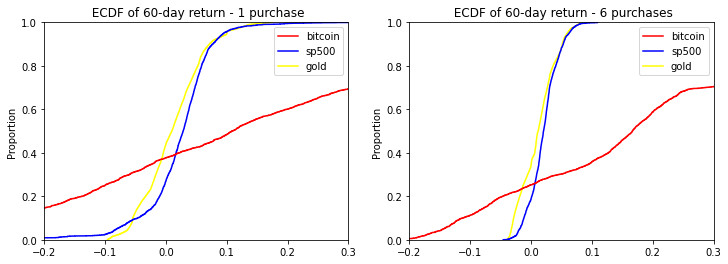

In [14]:
fig,axs=plt.subplots( 1,2,figsize=(12,4))
sns.ecdfplot(data=eff_return(60,1,30),palette=['red','blue','yellow'],ax=axs[0])
sns.ecdfplot(data=eff_return(60,6,30),palette=['red','blue','yellow'],ax=axs[1])

axs[0].set_xlim([-0.2,0.3])
axs[1].set_xlim([-0.2,0.3])

axs[0].set_title(' ECDF of 60-day return - 1 purchase')
axs[1].set_title(' ECDF of 60-day return - 6 purchases')

In the plot above we computed the ECDF of 60-day return for two different strategies, using period of sell =60 days.
The plot on the left shows the distribution of return for only 1 purchase(and sell) of bitcoin, and it show approximately 40% chance of negative return. On the other hand, plot on the right shows the distributon of return for 6 purchases (every 30 days) which shows approximately 25% chance of negative return.

The decrease of this probability occurs while the positive return probability stays high. Therefore we can conclude that we can minimize volatility of bitcoin investment by splitting the investment into several purchases.

We can do further analysis to find the optimal period of sell/buy that has lowest negative return probability. 


Text(0.5, 0, 'return ')

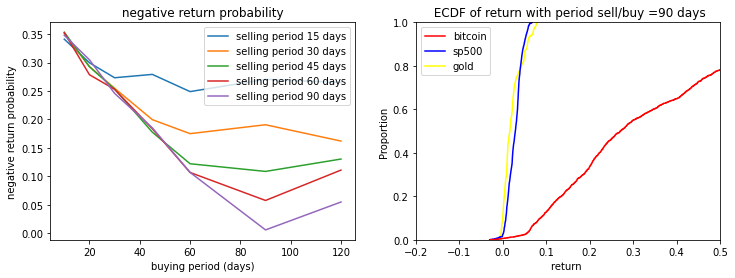

In [15]:
from statsmodels.distributions.empirical_distribution import ECDF
buying_periods=[ 10,20,30,45,60,90,120]
selling_periods=[15,30,45,60,90]
fig,axs=plt.subplots( 1,2,figsize=(12,4))

for period_sell in selling_periods:
    negative_prob=[]
    for period_buy in buying_periods:
        ecdf_bit=ECDF(eff_return(period_sell,6,period_buy)['bitcoin'])
        negative_prob.append(ecdf_bit(x)[-1])
    axs[0].plot(buying_periods,negative_prob,label='selling period '+str(period_sell) +' days')
    axs[0].set_ylabel('negative return probability')
    axs[0].set_xlabel('buying period (days)')
    axs[0].legend()
    axs[0].set_title(' negative return probability ')

    
sns.ecdfplot(data=eff_return(90,6,90),palette=['red','blue','yellow'],ax=axs[1])
axs[1].set_xlim([-0.2,0.5])
axs[1].set_title(' ECDF of return with period sell/buy =90 days')
axs[1].set_xlabel('return ')

From plot above we observe that buying period and selling periof of 90 days seems to give the lowest negative return probability

## Optimal Risk to Return Portfolio : Backtesting

Here i adopted a strategy to find the optimal portfolio from references : <br>  Portfolio Learning Based on Deep Learning by Wei Pan, Jide Li and Xiaoqiang Li.

A portfolio here is constructed from these 3 assets.
Part of the strategy i want to adopt is rather simple, which is :<br>

(1) Compute covariance matrix of the portoflio from day 1 to day 20, and find the best portfolio that maximize the sharpe ratio<br>
(2) Use the computed portfolio for day 21-30, and compute the return of that portoflio at day 30.<br>
(3) shift to data at 10 days ahead, and redo step (1)<br>

In the first part i will use backtest this strategy and compare portfolio growth to all 3 assets growth. In the second part, i will use machine learning portfolio using current stock prices to predict future optimal portfolio.


In [16]:
#p1 is the number of days to compute optimal portfolio weights
#p2 is the number of days afterward in which the weights is implemented
p1=20
p2=10

n= int( full_df.shape[0]/p2)  -int(p1/p2) 

covariances=[]
portf_weights=[]
portf_returns=[]
bitcoin_returns=[]
portf_sharpe=[]

def best_portfolio(covariances,return_i):
    portfolio_sharpe=[]
    portfolio_weights=[]
    portfolio_return=[]
    for portfolio in range(100):
        weights = np.random.random(3)
        weights /= np.sum(weights) 
        returns = np.dot(weights, returns_i )
        volatility = np.sqrt(np.dot(weights.T, np.dot(covariances, weights)))
        portfolio_sharpe.append( returns/volatility )
        portfolio_weights.append(weights)
        portfolio_return.append(returns)
    imax=np.argmax( portfolio_sharpe)
    p_w=portfolio_weights[imax]
    p_s= portfolio_sharpe[imax]
    p_r=portfolio_return[imax]
    return p_s,p_w,p_r



for i in range(n):
    covariances.append(returns_daily.iloc[i*p2:i*p2+p1].cov())
    returns_i=full_df.pct_change(periods=p1).dropna().iloc[i*p2]
    
    portfolio_sharpe,portfolio_weights,portfolio_return=best_portfolio(covariances[i],returns_i)
        
    portf_weights.append(portfolio_weights)
    portf_returns.append (portfolio_return )
    portf_sharpe.append( portfolio_sharpe )
    
portf_weights=np.array(portf_weights)
portf_returns=np.array(portf_returns)


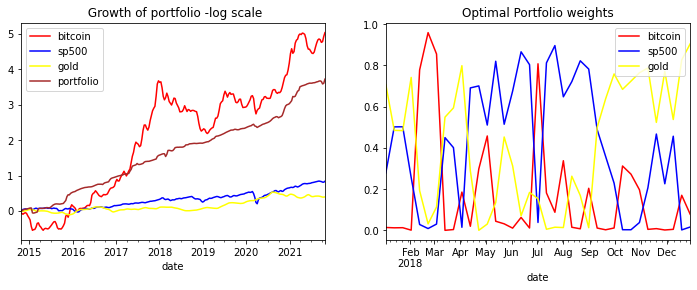

In [17]:
def plot_portfolio(full_df,portf_returns,portf_weights,p1,p2):
    fig,axs=plt.subplots( 1,2,figsize=(12,4))

    cash=1
    invest=[cash]
    
    invest_all=full_df.iloc[p1:]/full_df.iloc[p1]
    invest_all=invest_all.iloc[::p2]

    for i in range(n):
        invest.append( (1+portf_returns[i])*invest[i-1])
        
    invest_all['portfolio']=invest
    
    np.log(invest_all).rolling(2).mean().plot(ax=axs[0],color=['red','blue','yellow','brown'])

    axs[0].legend()
    axs[0].set_title(' Growth of portfolio -log scale')
    

    
    weights=pd.DataFrame( portf_weights,columns=['bitcoin','sp500','gold'])
    weights.set_index( invest_all.index[:-1],inplace=True)
    
    mask=(weights.index.year==2018) 
    weights.loc[mask].plot(ax=axs[1],color=['red','blue','yellow'])

    
    axs[1].set_title('Optimal Portfolio weights')
    
plot_portfolio(full_df,portf_returns,portf_weights,p1,p2)

The plot on the left shows how portfolio closely follows the bitcoin but without too much volatility. The plot on the right shows when bitcoin was going down(2018), the portfolio is mostly dominated by sp500 and gold.

In [18]:
#Let's compare how often the portfolio has negative return compare to the individual assets:

neg_return_portf=np.sum(np.roll(portf_returns,1)<0)/(len(portf_returns))

neg_return_individual=(full_df.pct_change(p2).dropna().iloc[::p2] <0 ).sum(axis=0)/ full_df.iloc[::p2].shape[0]

print('portoflio :',neg_return_portf)
print('bitcoin,sp500,gold:' , neg_return_individual.values)

portoflio : 0.14453125
bitcoin,sp500,gold: [0.40540541 0.34749035 0.47490347]


In our analysis we do backtesting of our simple strategy and compare the result to the individual assets:

(i) Our portfolio value went down only 12.5% of the time, this is signifficantly less often than the individual assets (bitcon,sp500, and gold) which are : 40%, 34%, and 47% of the time

(ii) The growth rate of portfolio is signifficantly larger than sp500 and gold. The portfolio growth is smaller but closely follows the growth of bitcoin but without too much volatility.




## Predicting Future Return of Portfolio

Predicting price changes is actually really difficult todo, especially for volatile asset like bitcoin. So here is just an early attempt to predict this, in particular we'll predict the  1 week return of bitcoin.

(1) I wil do weekly resampling of the original data, to reduce daily fluctuations that may led machine learning algorithm failure<br>
(2) We'll do feature Engineering that includes 1,2,and 3 Week Simple Moving Average( SMA) and Relative  Strenght Index (RSI).<br>
(3)The target is  1-week return in the future<br>
(4) We will use RandomForestRegressor with parameters :n_estimators=200, max_depth=5, max_features=4 <br>

In [19]:
#Resample the data wee
df_week=full_df.iloc[::7]

# Create a simple rsi function
def rsi(df, periods):
    delta = df.diff()
    up_days = delta.copy()
    up_days[delta<=0]=0.0
    down_days = abs(delta.copy())
    down_days[delta>0]=0.0
    RS_up = up_days.rolling(periods).mean()
    RS_down = down_days.rolling(periods).mean()
    rsi= 100-100/(1+RS_up/RS_down)
    return rsi



In [20]:
#Feature Engineering

#nshift =1 refers to 1-week return prediction
nshift=1

df_week['bitcoin_future']=df_week['bitcoin'].shift(-nshift)
df_week['bitcoin_future_pct']=df_week['bitcoin_future'].pct_change(nshift)
df_week['bitcoin_pct']=df_week['bitcoin'].pct_change(nshift)
feature_names=['bitcoin_pct']
for n in [1, 2,3]:

    # Create the moving average indicator and divide by bitcoin price
    df_week['ma' + str(n)] =df_week['bitcoin'].rolling(n).mean()
    # Create the RSI indicator
    df_week['rsi' + str(n)] = rsi(df_week['bitcoin'],n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    feature_names = feature_names + ['ma' + str(n)]
print(feature_names)

df_week=df_week.dropna()
features = df_week[feature_names]
targets = df_week['bitcoin_future_pct']
#targets = df_week['bitcoin_pct']


['bitcoin_pct', 'ma1', 'rsi1', 'ma1', 'ma2', 'rsi2', 'ma2', 'ma3', 'rsi3', 'ma3']


In [21]:
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
print(train_features.shape, test_features.shape)

(311, 10) (55, 10)


R2 score of train :  0.8577110636286679
R2 score of test :  -0.37527981326338034


Text(0.5, 1.0, ' bitcoin return prediction vs bitcoin return data ')

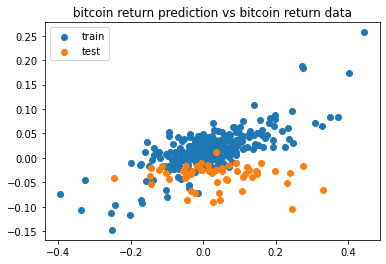

In [22]:

from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Compute R^2 scores on train and test
print('R2 score of train : ',rfr.score(train_features, train_targets))
print('R2 score of test : ',rfr.score(test_features,test_targets))

# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=5, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets,test_predictions,label='test')
plt.legend()
plt.title( ' bitcoin return prediction vs bitcoin return data ')



As we guessed, predicting future return is really difficult task todo , where here the prediction is quite off. More work need to be done with other algorithms to better predict the return.

## ⌛️ Time is ticking. Good luck!